# MCP-HaloTag testing

## Data import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from transcription_pipeline import preprocessing_pipeline
# Comments
RBSPWM_dataset1 = "test_data/2024-02-26/Halo-RBSPWM_embryo01"
RBSPWM_dataset2 = "test_data/2024-02-26/Halo-RBSPWM_embryo02"

RBSPWM_dataset3 = "test_data/2024-05-07/Halo552-RBSPWM_embryo01" # 1024x256, time res 4.2 seconds
RBSPWM_dataset4 = "test_data/2024-05-07/Halo552-RBSPWM_embryo02" # 800x300 

RBSPWM_dataset5 = "test_data/2024-05-09/Halo552-RBSPWM_embryo01" # 40x magnification

InputOutput_embryo1 = "test_data/InputOutput_MCPHaloTag/2024-03-07/embryo1"
InputOutput_embryo2 = "test_data/InputOutput_MCPHaloTag/2024-03-07/embryo2"

test_dataset_name = RBSPWM_dataset5

`JAVA_HOME` environment variable set to /mnt/Data1/Josh/miniforge3/envs/transcription_pipeline


In [2]:
# ## Import from scratch
# dataset = preprocessing_pipeline.DataImport(
#     name_folder=test_dataset_name,
#     trim_series=True,
#     working_storage_mode='zarr',
#     # import_previous=True, 
# )
# dataset.save()

In [3]:
## Load from zarr
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    # working_storage_mode='zarr',
    import_previous=True, 
)

### Starting a Dask Client for parallelization

In [4]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="6GB",
    )
    
    client = Client(cluster)
except:
    print("Cluster already running")
    client = Client('localhost:37763')

print(client)

<Client: 'tcp://127.0.0.1:37763' processes=14 threads=14, memory=78.23 GiB>


2024-06-13 13:54:28,682 - distributed.nanny - WARNING - Restarting worker
2024-06-13 13:54:28,687 - distributed.nanny - WARNING - Restarting worker
2024-06-13 13:54:28,689 - distributed.nanny - WARNING - Restarting worker
2024-06-13 13:54:28,696 - distributed.nanny - WARNING - Restarting worker
2024-06-13 13:54:28,700 - distributed.nanny - WARNING - Restarting worker
2024-06-13 13:54:28,703 - distributed.nanny - WARNING - Restarting worker
2024-06-13 13:54:28,707 - distributed.nanny - WARNING - Restarting worker
2024-06-13 13:54:28,731 - distributed.nanny - WARNING - Restarting worker
2024-06-13 13:54:28,732 - distributed.nanny - WARNING - Restarting worker
2024-06-13 13:54:28,740 - distributed.nanny - WARNING - Restarting worker
2024-06-13 13:54:28,746 - distributed.nanny - WARNING - Restarting worker
2024-06-13 13:54:28,750 - distributed.nanny - WARNING - Restarting worker
2024-06-13 13:54:28,751 - distributed.nanny - WARNING - Restarting worker
2024-06-13 13:54:28,753 - distributed.

In [5]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 14
Total threads: 14,Total memory: 78.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37763,Workers: 14
Dashboard: http://127.0.0.1:8787/status,Total threads: 14
Started: Just now,Total memory: 78.23 GiB
Comm: tcp://127.0.0.1:39941,Total threads: 1
Dashboard: http://127.0.0.1:46621/status,Memory: 5.59 GiB
Nanny: tcp://127.0.0.1:41377,


In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 14
Total threads: 14,Total memory: 78.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37763,Workers: 14
Dashboard: http://127.0.0.1:8787/status,Total threads: 14
Started: Just now,Total memory: 78.23 GiB
Comm: tcp://127.0.0.1:39941,Total threads: 1
Dashboard: http://127.0.0.1:46621/status,Memory: 5.59 GiB
Nanny: tcp://127.0.0.1:41377,


## Spot analysis

In [7]:
from transcription_pipeline import spot_pipeline

In [8]:
# %%time

# spot_tracking = spot_pipeline.Spot(
#     data=dataset.channels_full_dataset[0],
#     global_metadata=dataset.export_global_metadata[0],
#     frame_metadata=dataset.export_frame_metadata[0],
#     labels=None, #nuclear_tracking.reordered_nuclear_labels,
#     expand_distance=3,
#     retrack_search_range_um=3, # original value was 4.5 and had an issue of assigning two spots to a particle in a single frame
#     series_splits=dataset.series_splits,
#     series_shifts=dataset.series_shifts,
#     keep_bandpass=False,
#     keep_futures=False,
#     keep_spot_labels=False,
#     evaluate=True,
#     retrack_by_intensity=False,
#     client=client,
    
#     # Parameters to be tuned
#     threshold_factor=1.7,
#     search_range_um=1.5, # original value was 2.5
#     memory=3,
#     min_track_length=5,
#     retrack_after_filter=False
# )

# spot_tracking.extract_spot_traces(working_memory_folder=test_dataset_name, trackpy_log_path = test_dataset_name+'/trackpy_log')
# # Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
# # quantification information.
# spot_tracking.save_results(name_folder=test_dataset_name, save_array_as=None)

In [9]:
# The following dataset is marked as far posterior in the lab notebook

In [10]:
track_spots = spot_pipeline.Spot()

track_spots.read_results(name_folder=test_dataset_name)

In [11]:
spot_df = track_spots.spot_dataframe

In [12]:
detected_spots = spot_df[spot_df["particle"] != 0]

In [13]:
detected_spots['raw_spot'].head()

4    [[[6, 8, 3, 6, 3, 4, 5, 1, 0], [5, 2, 6, 7, 5,...
5    [[[4, 2, 0, 3, 4, 3, 6, 2, 2], [3, 3, 4, 4, 4,...
6    [[[4, 4, 1, 6, 7, 2, 4, 1, 6], [4, 7, 2, 2, 1,...
7    [[[2, 5, 1, 5, 1, 3, 3, 4, 1], [4, 4, 2, 4, 1,...
8    [[[0, 5, 1, 2, 4, 2, 2, 4, 1], [5, 3, 3, 2, 5,...
Name: raw_spot, dtype: object

## Compiling Data

In [14]:
from transcription_pipeline.spot_analysis import compile_data

In [15]:
compiled_dataframe = compile_data.compile_traces(
    detected_spots,
    compile_columns_spot=[
        "frame",
        "t_s",
        "intensity_from_neighborhood",
        "intensity_std_error_from_neighborhood",
        "x",
        "y"
    ],
    nuclear_tracking_dataframe=None,
)

In [16]:
compiled_dataframe

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y
0,1,"[486, 487, 488, 489, 490, 491, 492, 493, 494, ...","[2460.8920001983643, 2465.138999938965, 2469.3...","[312.2417752808989, 239.36774054054055, 261.74...","[48.258007730158944, 51.10832843063577, 45.349...","[816.0128816253126, 815.8107247539169, 816.694...","[169.96654532063292, 169.7021508593274, 169.27..."
1,2,"[616, 617, 618, 619, 620, 621, 622, 623, 624, ...","[3015.064001083374, 3019.312000274658, 3023.41...","[78.61329787234042, 172.2497697368421, 105.210...","[46.66242011083243, 51.62949386087655, 49.9161...","[704.863530220381, 704.4787642091378, 704.5966...","[131.97082632583715, 130.9860846929298, 131.93..."
2,3,"[523, 524, 525, 526, 527, 528, 529, 530, 531, ...","[2619.1630001068115, 2623.4190006256104, 2627....","[194.74518497109827, 157.8957894736842, 188.48...","[43.11534354278714, 48.54884884993402, 46.5440...","[797.4540223295935, 798.2418502161781, 798.930...","[113.56023983997694, 113.82520703270626, 114.0..."
3,4,"[591, 592, 594, 597, 599, 600, 601, 602, 603, ...","[2908.7880001068115, 2913.037000656128, 2921.5...","[114.75271428571429, 183.49992, 119.5002514619...","[43.401897516723324, 46.66763459179819, 43.179...","[828.1150934478264, 830.4877743845481, 829.574...","[152.13494395305608, 150.3216038103879, 150.97..."
4,5,"[465, 466, 467, 468, 469, 471, 473, 474, 475, ...","[2353.943000793457, 2358.198999404907, 2362.44...","[131.03238547486032, 137.67305333333334, 201.7...","[46.70524474311073, 50.51775293244764, 49.8382...","[625.9868432780078, 626.4931747381858, 626.005...","[203.99181891789277, 204.1437561886244, 202.78..."
...,...,...,...,...,...,...,...
1323,1331,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...","[1.8069992065429688, 6.062999725341797, 10.313...","[1353.7865614035088, 1504.4288961038962, 1363....","[84.07152484500466, 87.27623210569732, 81.7150...","[244.29564344655913, 244.9826986127202, 245.42...","[12.698963915346702, 12.4302420472441, 11.8267..."
1324,1332,"[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 1...","[2.006999969482422, 10.715999603271484, 14.966...","[1066.4280649350649, 975.9010273972603, 1067.8...","[74.5284118414619, 85.86387670184509, 76.34063...","[373.20212186442706, 375.41584604606663, 374.5...","[248.4983059870729, 249.44688082206247, 250.50..."
1325,1333,[13],[52.739999771118164],[43.69018497109826],[49.85410603500411],[408.2155234174165],[220.75288725990825]
1326,1334,"[5, 6, 7, 8, 9]","[18.2189998626709, 22.47599983215332, 26.52699...","[132.4031219512195, 77.9710177514793, 137.8095...","[50.57684452779804, 48.74531959986123, 51.0503...","[5.018386757676929, 5.054798318324925, 5.21269...","[250.18848608202862, 250.17146080014305, 250.6..."


## Visualizing traces

In [17]:
from transcription_pipeline.utils import plottable

In [18]:
# Restriction on trace length
min_frames = 80
traces_compiled_dataframe = compiled_dataframe[
    compiled_dataframe["frame"].apply(lambda x: x.size) > min_frames
]

# max_frames = 10
# traces_compiled_dataframe = traces_compiled_dataframe[
#     traces_compiled_dataframe["frame"].apply(lambda x: x.size) <= max_frames
# ]

In [19]:
plt.close()

#### Spot intensity vs. time

/mnt/Data1/Josh/transcription_pipeline-main/transcription_pipeline/utils/plottable.py:17: UserWarning: Could not determine division time, using absolute time.
  warnings.warn("Could not determine division time, using absolute time.")


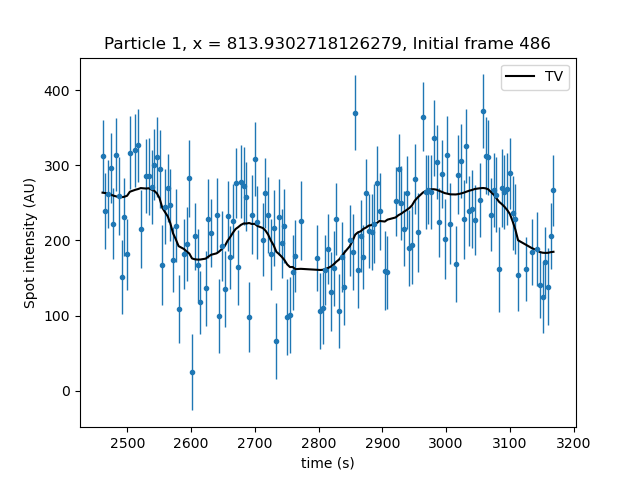

In [20]:
%matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib.pyplot as plt

from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle


traces = plottable.generate_trace_plot_list(traces_compiled_dataframe)
# median_filtered_traces = [medfilt(trace[1], kernel_size=9) for trace in traces]

tv_denoised_traces = [
    denoise_tv_chambolle(trace[1], weight=180, max_num_iter=500) for trace in traces
]
# potts_steps_traces = [
#     potts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.errorbar(
        traces[curr_pos][0],
        traces[curr_pos][1],
        yerr=traces[curr_pos][2],
        fmt=".",
        elinewidth=1,
    )
    # ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
    ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
    # ax.step(
    #     traces[curr_pos][0],
    #     potts_steps_traces[curr_pos],
    #     where="mid",
    #     color="red",
    #     label="Potts L1",
    # )
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")

    particle = traces[curr_pos][3]
    mean_x = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
        .values[0]
        .mean()
    )
    initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
    )
    ax.set_title(f"Particle {particle}, x = {mean_x}, Initial frame {initial_frame}")
    ax.legend()
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.errorbar(
    traces[curr_pos][0],
    traces[curr_pos][1],
    yerr=traces[curr_pos][2],
    fmt=".",
    elinewidth=1,
)
# ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
# ax.step(
#     traces[curr_pos][0],
#     potts_steps_traces[curr_pos],
#     where="mid",
#     color="red",
#     label="Potts L1",
# )
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")

particle = traces[curr_pos][3]
mean_x = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
    .values[0]
    .mean()
)
initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
)
ax.set_title(f"Particle {particle}, x = {mean_x}, Initial frame {initial_frame}")
ax.legend()

plt.show()

#### The same plot above but with frame in x axis

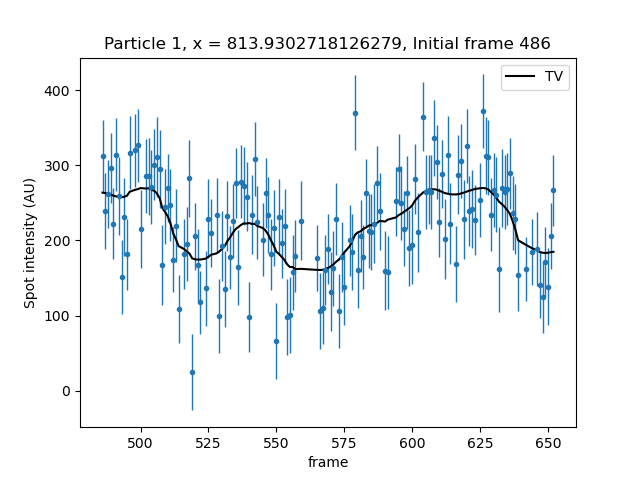

In [21]:
%matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib.pyplot as plt

from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle


traces = plottable.generate_trace_plot_list(traces_compiled_dataframe)
# median_filtered_traces = [medfilt(trace[1], kernel_size=9) for trace in traces]

tv_denoised_traces = [
    denoise_tv_chambolle(trace[1], weight=180, max_num_iter=500) for trace in traces
]
# potts_steps_traces = [
#     potts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.errorbar(
        np.array(traces_compiled_dataframe["frame"])[curr_pos],
        traces[curr_pos][1],
        yerr=traces[curr_pos][2],
        fmt=".",
        elinewidth=1,
    )
    # ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
    ax.plot(np.array(traces_compiled_dataframe["frame"])[curr_pos], tv_denoised_traces[curr_pos], color="k", label="TV")
    # ax.step(
    #     traces[curr_pos][0],
    #     potts_steps_traces[curr_pos],
    #     where="mid",
    #     color="red",
    #     label="Potts L1",
    # )
    ax.set_xlabel("frame")
    ax.set_ylabel("Spot intensity (AU)")

    particle = traces[curr_pos][3]
    mean_x = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
        .values[0]
        .mean()
    )
    initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
    )
    ax.set_title(f"Particle {particle}, x = {mean_x}, Initial frame {initial_frame}")
    ax.legend()
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.errorbar(
    np.array(traces_compiled_dataframe["frame"])[curr_pos],
    traces[curr_pos][1],
    yerr=traces[curr_pos][2],
    fmt=".",
    elinewidth=1,
)
# ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
ax.plot(np.array(traces_compiled_dataframe["frame"])[curr_pos], tv_denoised_traces[curr_pos], color="k", label="TV")
# ax.step(
#     traces[curr_pos][0],
#     potts_steps_traces[curr_pos],
#     where="mid",
#     color="red",
#     label="Potts L1",
# )
ax.set_xlabel("frame")
ax.set_ylabel("Spot intensity (AU)")

particle = traces[curr_pos][3]
mean_x = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
    .values[0]
    .mean()
)
initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
)
ax.set_title(f"Particle {particle}, x = {mean_x}, Initial frame {initial_frame}")
ax.legend()
traces_compiled_dataframe
plt.show()

## Binning & Average of Data Points

### Binning & Average

In [22]:
# insert a column indicating the average position of the particle

particle_num = compiled_dataframe.shape[0]

# create a list of mean x position
mean_x = []
for i in range(particle_num):
    mean = np.mean(compiled_dataframe["x"][i])
    mean_x.append(mean)

# create a list of particle start frames
start_frame = []
for i in range(particle_num):
    start = np.min(compiled_dataframe["frame"][i])
    start_frame.append(start)

# append the mean x position to a temporary data frame
compiled_dataframe_temp = compiled_dataframe[:]

compiled_dataframe_temp.insert(compiled_dataframe_temp.shape[1], "mean_x", mean_x)
compiled_dataframe_temp.insert(compiled_dataframe_temp.shape[1], "bin", [None]*particle_num)
compiled_dataframe_temp.insert(compiled_dataframe_temp.shape[1], "start_frame", start_frame)

compiled_dataframe_temp

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,mean_x,bin,start_frame
0,1,"[486, 487, 488, 489, 490, 491, 492, 493, 494, ...","[2460.8920001983643, 2465.138999938965, 2469.3...","[312.2417752808989, 239.36774054054055, 261.74...","[48.258007730158944, 51.10832843063577, 45.349...","[816.0128816253126, 815.8107247539169, 816.694...","[169.96654532063292, 169.7021508593274, 169.27...",813.930272,None,486
1,2,"[616, 617, 618, 619, 620, 621, 622, 623, 624, ...","[3015.064001083374, 3019.312000274658, 3023.41...","[78.61329787234042, 172.2497697368421, 105.210...","[46.66242011083243, 51.62949386087655, 49.9161...","[704.863530220381, 704.4787642091378, 704.5966...","[131.97082632583715, 130.9860846929298, 131.93...",705.349331,None,616
2,3,"[523, 524, 525, 526, 527, 528, 529, 530, 531, ...","[2619.1630001068115, 2623.4190006256104, 2627....","[194.74518497109827, 157.8957894736842, 188.48...","[43.11534354278714, 48.54884884993402, 46.5440...","[797.4540223295935, 798.2418502161781, 798.930...","[113.56023983997694, 113.82520703270626, 114.0...",793.276610,None,523
3,4,"[591, 592, 594, 597, 599, 600, 601, 602, 603, ...","[2908.7880001068115, 2913.037000656128, 2921.5...","[114.75271428571429, 183.49992, 119.5002514619...","[43.401897516723324, 46.66763459179819, 43.179...","[828.1150934478264, 830.4877743845481, 829.574...","[152.13494395305608, 150.3216038103879, 150.97...",826.438267,None,591
4,5,"[465, 466, 467, 468, 469, 471, 473, 474, 475, ...","[2353.943000793457, 2358.198999404907, 2362.44...","[131.03238547486032, 137.67305333333334, 201.7...","[46.70524474311073, 50.51775293244764, 49.8382...","[625.9868432780078, 626.4931747381858, 626.005...","[203.99181891789277, 204.1437561886244, 202.78...",621.743993,None,465
...,...,...,...,...,...,...,...,...,...,...
1323,1331,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...","[1.8069992065429688, 6.062999725341797, 10.313...","[1353.7865614035088, 1504.4288961038962, 1363....","[84.07152484500466, 87.27623210569732, 81.7150...","[244.29564344655913, 244.9826986127202, 245.42...","[12.698963915346702, 12.4302420472441, 11.8267...",248.842872,None,1
1324,1332,"[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 1...","[2.006999969482422, 10.715999603271484, 14.966...","[1066.4280649350649, 975.9010273972603, 1067.8...","[74.5284118414619, 85.86387670184509, 76.34063...","[373.20212186442706, 375.41584604606663, 374.5...","[248.4983059870729, 249.44688082206247, 250.50...",376.203182,None,1
1325,1333,[13],[52.739999771118164],[43.69018497109826],[49.85410603500411],[408.2155234174165],[220.75288725990825],408.215523,None,13
1326,1334,"[5, 6, 7, 8, 9]","[18.2189998626709, 22.47599983215332, 26.52699...","[132.4031219512195, 77.9710177514793, 137.8095...","[50.57684452779804, 48.74531959986123, 51.0503...","[5.018386757676929, 5.054798318324925, 5.21269...","[250.18848608202862, 250.17146080014305, 250.6...",5.594935,None,5


In [23]:
# Assign a bin number to each particle

x_dim = 1024 # x dimension of the image
bin_num = 16 # number of bins

bin_part = np.linspace(0, x_dim, bin_num+1) # partition bins

# assign each particle to a bin
for i in range(particle_num): # for each particle
    mean_x = compiled_dataframe_temp["mean_x"][i]
    
    for bin in range(bin_num): # for each bin
        if mean_x >= bin_part[bin] and mean_x < bin_part[bin+1]:
            compiled_dataframe_temp["bin"][i] = bin
        else:
            continue

/tmp/ipykernel_2314120/3087352505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_dataframe_temp["bin"][i] = bin
/tmp/ipykernel_2314120/3087352505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_dataframe_temp["bin"][i] = bin
/tmp/ipykernel_2314120/3087352505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compiled_dataframe_temp["bin"][i] = bin
/tmp/ipykernel_2314120/3087352505.py:14: SettingWithCopyWa

In [24]:
compiled_dataframe_temp

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,mean_x,bin,start_frame
0,1,"[486, 487, 488, 489, 490, 491, 492, 493, 494, ...","[2460.8920001983643, 2465.138999938965, 2469.3...","[312.2417752808989, 239.36774054054055, 261.74...","[48.258007730158944, 51.10832843063577, 45.349...","[816.0128816253126, 815.8107247539169, 816.694...","[169.96654532063292, 169.7021508593274, 169.27...",813.930272,12,486
1,2,"[616, 617, 618, 619, 620, 621, 622, 623, 624, ...","[3015.064001083374, 3019.312000274658, 3023.41...","[78.61329787234042, 172.2497697368421, 105.210...","[46.66242011083243, 51.62949386087655, 49.9161...","[704.863530220381, 704.4787642091378, 704.5966...","[131.97082632583715, 130.9860846929298, 131.93...",705.349331,11,616
2,3,"[523, 524, 525, 526, 527, 528, 529, 530, 531, ...","[2619.1630001068115, 2623.4190006256104, 2627....","[194.74518497109827, 157.8957894736842, 188.48...","[43.11534354278714, 48.54884884993402, 46.5440...","[797.4540223295935, 798.2418502161781, 798.930...","[113.56023983997694, 113.82520703270626, 114.0...",793.276610,12,523
3,4,"[591, 592, 594, 597, 599, 600, 601, 602, 603, ...","[2908.7880001068115, 2913.037000656128, 2921.5...","[114.75271428571429, 183.49992, 119.5002514619...","[43.401897516723324, 46.66763459179819, 43.179...","[828.1150934478264, 830.4877743845481, 829.574...","[152.13494395305608, 150.3216038103879, 150.97...",826.438267,12,591
4,5,"[465, 466, 467, 468, 469, 471, 473, 474, 475, ...","[2353.943000793457, 2358.198999404907, 2362.44...","[131.03238547486032, 137.67305333333334, 201.7...","[46.70524474311073, 50.51775293244764, 49.8382...","[625.9868432780078, 626.4931747381858, 626.005...","[203.99181891789277, 204.1437561886244, 202.78...",621.743993,9,465
...,...,...,...,...,...,...,...,...,...,...
1323,1331,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15...","[1.8069992065429688, 6.062999725341797, 10.313...","[1353.7865614035088, 1504.4288961038962, 1363....","[84.07152484500466, 87.27623210569732, 81.7150...","[244.29564344655913, 244.9826986127202, 245.42...","[12.698963915346702, 12.4302420472441, 11.8267...",248.842872,3,1
1324,1332,"[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 1...","[2.006999969482422, 10.715999603271484, 14.966...","[1066.4280649350649, 975.9010273972603, 1067.8...","[74.5284118414619, 85.86387670184509, 76.34063...","[373.20212186442706, 375.41584604606663, 374.5...","[248.4983059870729, 249.44688082206247, 250.50...",376.203182,5,1
1325,1333,[13],[52.739999771118164],[43.69018497109826],[49.85410603500411],[408.2155234174165],[220.75288725990825],408.215523,6,13
1326,1334,"[5, 6, 7, 8, 9]","[18.2189998626709, 22.47599983215332, 26.52699...","[132.4031219512195, 77.9710177514793, 137.8095...","[50.57684452779804, 48.74531959986123, 51.0503...","[5.018386757676929, 5.054798318324925, 5.21269...","[250.18848608202862, 250.17146080014305, 250.6...",5.594935,0,5


In [25]:
# sort particles by bins

binned_particles = [None]*bin_num

for bin in range(bin_num): # for each bin
    mask = compiled_dataframe_temp["bin"] == bin
    binned_particles[bin] = compiled_dataframe_temp[mask]

binned_particles[12]

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,mean_x,bin,start_frame
0,1,"[486, 487, 488, 489, 490, 491, 492, 493, 494, ...","[2460.8920001983643, 2465.138999938965, 2469.3...","[312.2417752808989, 239.36774054054055, 261.74...","[48.258007730158944, 51.10832843063577, 45.349...","[816.0128816253126, 815.8107247539169, 816.694...","[169.96654532063292, 169.7021508593274, 169.27...",813.930272,12,486
2,3,"[523, 524, 525, 526, 527, 528, 529, 530, 531, ...","[2619.1630001068115, 2623.4190006256104, 2627....","[194.74518497109827, 157.8957894736842, 188.48...","[43.11534354278714, 48.54884884993402, 46.5440...","[797.4540223295935, 798.2418502161781, 798.930...","[113.56023983997694, 113.82520703270626, 114.0...",793.276610,12,523
3,4,"[591, 592, 594, 597, 599, 600, 601, 602, 603, ...","[2908.7880001068115, 2913.037000656128, 2921.5...","[114.75271428571429, 183.49992, 119.5002514619...","[43.401897516723324, 46.66763459179819, 43.179...","[828.1150934478264, 830.4877743845481, 829.574...","[152.13494395305608, 150.3216038103879, 150.97...",826.438267,12,591
12,13,"[620, 622, 623, 624, 625, 626, 627, 628, 629, ...","[3032.923999786377, 3041.4190006256104, 3045.6...","[178.00075757575758, 133.63512865497077, 144.6...","[50.034004234870345, 41.43627203486614, 44.743...","[803.4203632444618, 801.9576930746124, 801.902...","[227.4350772771209, 228.16390573844973, 227.72...",800.476755,12,620
21,22,"[632, 635, 636, 638, 639, 640, 641, 642, 643, ...","[3083.859001159668, 3096.404001235962, 3100.86...","[213.34527272727271, 141.11465217391304, 108.1...","[43.59663685906847, 50.028908830526746, 51.516...","[788.1814759631841, 788.8962965930089, 789.119...","[184.38236551951059, 184.41679665522298, 184.2...",787.573408,12,632
...,...,...,...,...,...,...,...,...,...,...
1309,1317,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2.006999969482422, 6.062999725341797, 10.5159...","[1340.0328444444444, 1329.2872457142857, 1307....","[79.495138136966, 75.38959132967048, 73.129646...","[823.9873394506576, 825.1166150784088, 824.276...","[9.943819838796761, 10.092025548209001, 8.8800...",820.576129,12,1
1314,1322,[34],[143.6029987335205],[78.06603314917128],[47.22579650326229],[817.022465621828],[155.9709879885791],817.022466,12,34
1315,1323,[33],[136.88299942016602],[82.93141279069768],[49.22083322534756],[826.154309207389],[63.4889203515084],826.154309,12,33
1322,1330,[24],[98.52699851989746],[82.779625],[50.11542673382831],[778.7133623070058],[109.96685579733905],778.713362,12,24


In [26]:
# sort intensity data based on bin and frame

intensity_by_frame = [[] for _ in range(bin_num)]

for bin in range(bin_num):
        
    # find the max and min frame number in a bin
    try:
        max_frame = max(binned_particles[bin]["frame"].apply(max))
        min_frame = min(binned_particles[bin]["frame"].apply(min))
        
        intensity_by_frame[bin] = pd.DataFrame({'frame': range(min_frame,max_frame), 
                             'intensity': [[] for _ in range(0,max_frame-min_frame)], 
                             'average_intensity': [None for _ in range(0,max_frame-min_frame)],
                            'std_err_intensity': [None for _ in range(0,max_frame-min_frame)]})
        
        bin_particle_num = binned_particles[bin].shape[0]
        
        intensity_list = [[]]*(max_frame-min_frame)
        for frame in range(min_frame, max_frame): # for each frame along the movie
            FrameIndex = frame - min_frame
            
            for particle in range(bin_particle_num): # for each particle in the bin
                particle_frames = np.array(binned_particles[bin])[particle][1] # extract the frame list of a single particle
                particle_intensity = np.array(binned_particles[bin])[particle][3] # extract the intensity list of a single particle
                
                for el in range(len(particle_frames)): # for each frame of this particle
                    if particle_frames[el] == frame:
                        # add the intensity value of this particle at this frame to the new data structure
                        intensity_by_frame[bin]['intensity'][FrameIndex].append(particle_intensity[el])
    except:
        continue

In [27]:
# for each bin, calculate the average intensity in each frame along with the standard error

for bin in range(bin_num):
    try:
        frame_num = intensity_by_frame[bin].shape[0]
        for frame in range(frame_num):
            intensity_data = intensity_by_frame[bin]['intensity'][frame]
            intensity_by_frame[bin]['average_intensity'][frame] = np.mean(intensity_data)
            intensity_by_frame[bin]['std_err_intensity'][frame] = np.std(intensity_data)/np.sqrt(len(intensity_data))
    except:
        continue

/tmp/ipykernel_2314120/902731023.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intensity_by_frame[bin]['average_intensity'][frame] = np.mean(intensity_data)
/tmp/ipykernel_2314120/902731023.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intensity_by_frame[bin]['std_err_intensity'][frame] = np.std(intensity_data)/np.sqrt(len(intensity_data))
/tmp/ipykernel_2314120/902731023.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

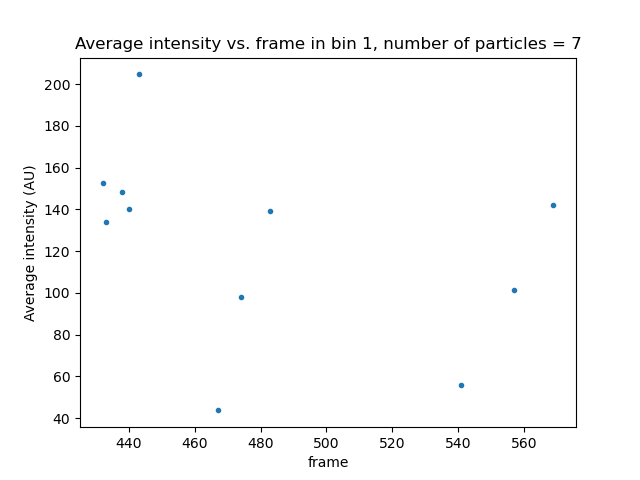

In [45]:
%matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib.pyplot as plt

from scipy.signal import medfilt

curr_bin = 0


def key_event1(e):
    global curr_bin

    if e.key == "right":
        curr_bin = curr_bin + 1
    elif e.key == "left":
        curr_bin = curr_bin - 1
    else:
        return
    curr_bin = curr_bin % bin_num

    NC14_mask = list(intensity_by_frame[curr_bin]['frame'] >= 400) # take 400 as the start of NC14

    # number of particles in NC14 in a bin
    curr_bin_particles = binned_particles[curr_bin]
    NC14_particles = curr_bin_particles[curr_bin_particles['start_frame'] >= 400]
    num = len(NC14_particles)
    
    x = intensity_by_frame[curr_bin]['frame'][NC14_mask]
    y = intensity_by_frame[curr_bin]['average_intensity'][NC14_mask]
    y_err = intensity_by_frame[curr_bin]['std_err_intensity'][NC14_mask]
    
    ax.cla()
    
    ax.errorbar(x, 
                y, 
                yerr=y_err,
                fmt=".",
                elinewidth=1,)
    
    ax.set_xlabel("frame")
    ax.set_ylabel("Average intensity (AU)")
    ax.set_title(f"Average intensity vs. frame in bin {curr_bin+1}, number of particles = {num}")
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event1)

ax = fig.add_subplot(111)

NC14_mask = list(intensity_by_frame[curr_bin]['frame'] >= 400)

# number of particles in NC14 in a bin
curr_bin_particles = binned_particles[curr_bin]
NC14_particles = curr_bin_particles[curr_bin_particles['start_frame'] >= 400]
num = len(NC14_particles)

x = intensity_by_frame[curr_bin]['frame'][NC14_mask]
y = intensity_by_frame[curr_bin]['average_intensity'][NC14_mask]
y_err = intensity_by_frame[curr_bin]['std_err_intensity'][NC14_mask]

ax.errorbar(x, 
            y, 
            yerr=y_err,
            fmt=".",
            elinewidth=1,)

ax.set_xlabel("frame")
ax.set_ylabel("Average intensity (AU)")
ax.set_title(f"Average intensity vs. frame in bin {curr_bin+1}, number of particles = {num}")
plt.show()

# Note that here bin 16 is empty so you will see a plot with nothing

Same plot but with time into NC14 on x axis

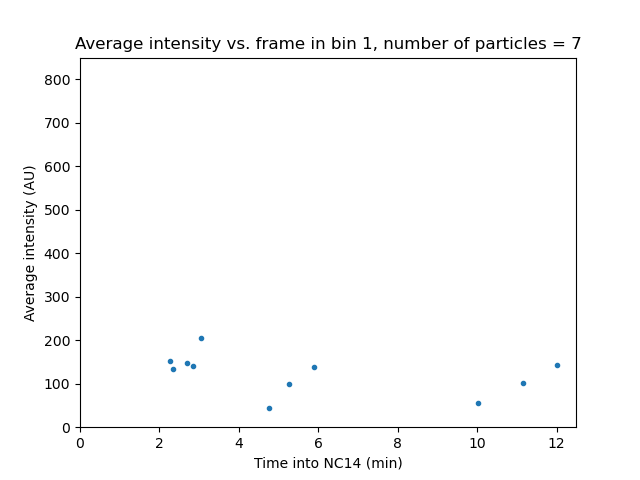

In [125]:
%matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib.pyplot as plt

from scipy.signal import medfilt

curr_bin = 0


def key_event1(e):
    global curr_bin

    if e.key == "right":
        curr_bin = curr_bin + 1
    elif e.key == "left":
        curr_bin = curr_bin - 1
    else:
        return
    curr_bin = curr_bin % bin_num

    NC14_mask = list(intensity_by_frame[curr_bin]['frame'] >= 400) # take 400 as the start of NC14

    # number of particles in NC14 in a bin
    curr_bin_particles = binned_particles[curr_bin]
    NC14_particles = curr_bin_particles[curr_bin_particles['start_frame'] >= 400]
    num = len(NC14_particles)
    
    x = (intensity_by_frame[curr_bin]['frame'][NC14_mask] - 400)*4.25939/60
    y = intensity_by_frame[curr_bin]['average_intensity'][NC14_mask]
    y_err = intensity_by_frame[curr_bin]['std_err_intensity'][NC14_mask]
    
    ax.cla()
    
    ax.errorbar(x, 
                y, 
                yerr=y_err,
                fmt=".",
                elinewidth=1,)
    
    ax.set_xlabel("Time into NC14 (min)")
    ax.set_ylabel("Average intensity (AU)")
    ax.set_xlim(0,)
    ax.set_ylim(0,850)
    ax.set_title(f"Average intensity vs. frame in bin {curr_bin+1}, number of particles = {num}")
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event1)

ax = fig.add_subplot(111)

NC14_mask = list(intensity_by_frame[curr_bin]['frame'] >= 400)

# number of particles in NC14 in a bin
curr_bin_particles = binned_particles[curr_bin]
NC14_particles = curr_bin_particles[curr_bin_particles['start_frame'] >= 400]
num = len(NC14_particles)

x = (intensity_by_frame[curr_bin]['frame'][NC14_mask] - 400)*4.25939/60
y = intensity_by_frame[curr_bin]['average_intensity'][NC14_mask]
y_err = intensity_by_frame[curr_bin]['std_err_intensity'][NC14_mask]

ax.errorbar(x, 
            y, 
            yerr=y_err,
            fmt=".",
            elinewidth=1,)

ax.set_xlabel("Time into NC14 (min)")
ax.set_ylabel("Average intensity (AU)")
ax.set_xlim(0,)
ax.set_ylim(0,850)
ax.set_title(f"Average intensity vs. frame in bin {curr_bin+1}, number of particles = {num}")
plt.show()

# Note that here bin 16 is empty so you will see a plot with nothing

In [145]:
plt.close()

## YJK's Fit Functions

/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


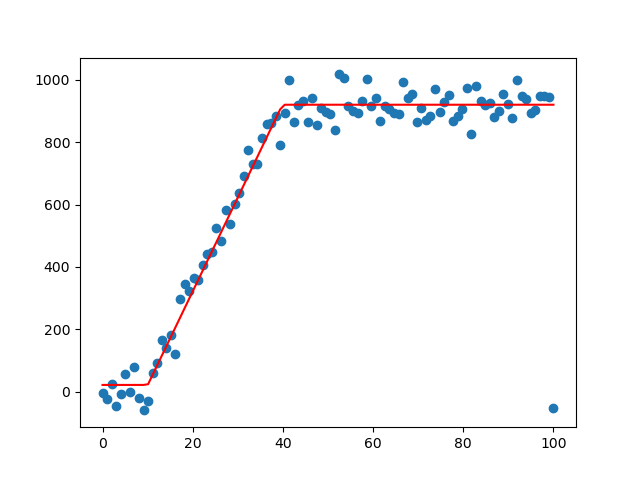

In [146]:
# function to fit piecewise curve with a low constant portion, a linear increase portion, a high constant portion, and a decay portion
# install the package first by running !pip install scipy

#!pip install scipy

from scipy.optimize import curve_fit

def piecewise_linear(x, a, v1, m, b, c):
    # x = np.asarray(x)  # Ensure x is a numpy array

    # Create an array to hold the results
    result = np.full_like(x, np.nan)  # Start with all values as NaN

    # Apply the piecewise conditions
    mask1 = x < a
    mask2 = (x >= a) & (x < b)
    mask3 = (x >= b) & (x < c)
    mask4 = x >= c

    result[mask1] = v1
    result[mask2] = v1 + m*(x[mask2] - a)
    result[mask3] = v1 + m * (b - a)
    result[mask4] = 0

    return result


def fit_piecewise_linear(x, y, y_err):
    p0 = [0, np.min(y), 10, 0, np.max(x)]
    popt, pcov = curve_fit(piecewise_linear, x, y, sigma=y_err, p0=p0)
    return popt, pcov

# Generate sample data

x = np.linspace(0, 100, 100)
y = piecewise_linear(x, 10, 20, 30, 40, 100)


# add noise to the data
y_noise = 40* np.random.normal(size=x.size)

ydata = y + y_noise

# Fit the model
popt, pcov = fit_piecewise_linear(x, ydata, y_noise)

plt.close()
plt.scatter(x, ydata,label='data')
plt.plot(x, piecewise_linear(x, *popt), 'r-', label='fit')
plt.show()

In [174]:
import numpy as np
from scipy.optimize import least_squares

def make_whole_cycle(basal, t_on, t_dwell, t_active, tau, rate, t_interp):
    signal = np.zeros_like(t_interp)  # Output signal
    dt = t_interp[1] - t_interp[0]    # Time resolution
    ind_shift = int(np.floor(t_dwell / dt))  # Number of indices to shift for dwell time

    # Generate loading rate
    rate_cycle = np.full_like(t_interp, np.nan)  # Loading rate for the nuclear cycle
    rate_cycle[t_interp < t_on] = 0
    mask1 = (t_interp >= t_on) & (t_interp < (t_on + t_dwell + t_active))
    rate_cycle[mask1] = rate

    for i in range(len(t_interp)):
        if t_interp[i] >= (t_on + t_dwell + t_active):
            rate_cycle[i] = rate * np.exp(-(t_interp[i] - t_on - t_dwell - t_active) / tau)

    # Generate signal
    for i in range(1, len(t_interp)):
        if t_interp[i] > t_on and t_interp[i] <= (t_on + t_dwell):
            signal[i] = signal[i-1] + dt * rate_cycle[i-1]
        elif t_interp[i] > (t_on + t_dwell):
            if (i-1-ind_shift) < 0:  # Check for zero indexing error
                ind_shift = ind_shift - 1
            signal[i] = signal[i-1] + (rate_cycle[i-1] - rate_cycle[i-1-ind_shift]) * dt

    # Add basal fluorescence
    signal[signal < basal] = basal

    return signal

def fit_func(params, MS2, timepoints, t_interp):
    return np.interp(timepoints, t_interp, make_whole_cycle(*params, t_interp)) - MS2

def fit_whole_cycle(MS2, timepoints, t_interp, max_nfev=1000, initial_guess=[1,20,20,10,15,100]):
    # Initial guesses for the parameters
    basal0 = initial_guess[0]
    t_on0 = initial_guess[1]
    t_dwell0 = initial_guess[2]
    t_active0 = initial_guess[3]
    tau0 = initial_guess[4]
    rate0 = initial_guess[5]
    x0 = [basal0, t_on0, t_dwell0, t_active0, tau0, rate0]

    # Parameter bounds
    lb = [np.min(MS2), 0, 0, -2, 0, 0]
    ub = [np.max(MS2), 20, 20, 30, 50, 1e7]

    # Perform the fit
    res = least_squares(fit_func, x0, bounds=(lb, ub), args=(MS2, timepoints, t_interp), max_nfev=max_nfev)

    # Extract fit parameters
    basal, t_on, t_dwell, t_active, tau, rate = res.x
    resnorm = res.cost / len(MS2)  # Normalize residual norm by number of datapoints
    residual = res.fun

    # Calculate confidence intervals
    from scipy.stats import chi2
    alpha = 0.05  # 95% confidence interval
    dof = len(MS2) - len(res.x)
    tval = chi2.ppf(1.0 - alpha / 2., dof)

    pcov = np.linalg.inv(res.jac.T.dot(res.jac)) * res.cost / dof
    perr = np.sqrt(np.diag(pcov))
    CI = np.array([res.x - tval * perr, res.x + tval * perr]).T

    return basal, t_on, t_dwell, t_active, tau, rate, residual, resnorm, CI


In [175]:
plt.close()

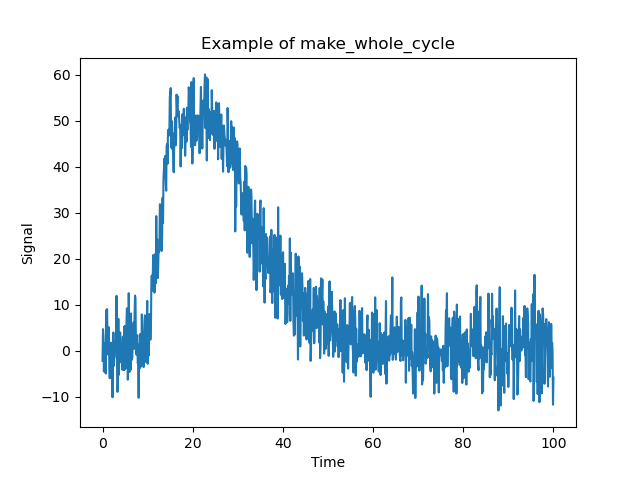

In [188]:
# Plot example of make_whole_cycle
t_interp = np.linspace(0, 100, 1000)
signal = make_whole_cycle(1, 10, 5, 10, 10, 10, t_interp)

# Add noise
signal += np.random.normal(0, 5, len(signal))

plt.figure()
plt.plot(t_interp, signal)
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Example of make_whole_cycle')
plt.show()

Fitted parameters:
basal: 0.792143319168003, t_on: 8.808808364871087, t_dwell: 8.808808389886414, t_active: 3.851217222879797, tau: 10.778012996116463, rate: 6.0848478676790485
Residual norm: 14.282402149625765
basal: [-210.97044311  212.55472975]
t_on: [-2.22053242e+10  2.22053242e+10]
t_dwell: [-2.12089829e+10  2.12089829e+10]
t_active: [-1.33302760e+09  1.33302761e+09]
tau: [-817.43956781  838.9955938 ]
rate: [-43.81775063  55.98744636]


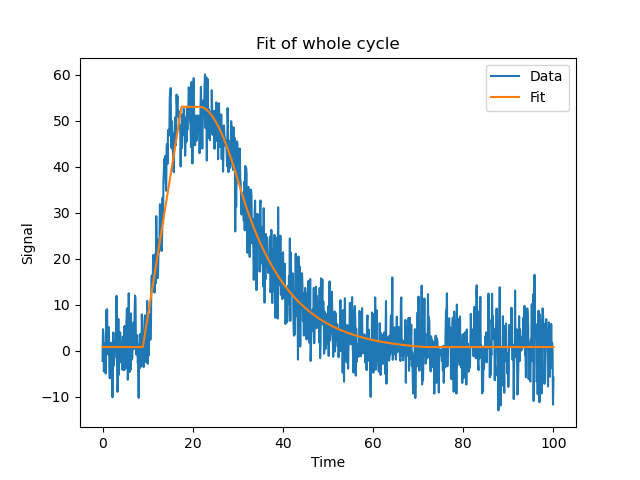

In [200]:
# Example usage
timepoints = t_interp  # Your timepoints data here
MS2 = signal  # Your MS2 data here
t_interp = np.linspace(min(timepoints), max(timepoints), 1000)

basal, t_on, t_dwell, t_active, tau, rate, residual, resnorm, CI = fit_whole_cycle(MS2, timepoints, t_interp, max_nfev=2000)

print("Fitted parameters:")
print(f"basal: {basal}, t_on: {t_on}, t_dwell: {t_dwell}, t_active: {t_active}, tau: {tau}, rate: {rate}")
print(f"Residual norm: {resnorm}")

# Print confidence intervals and parameter names
param_names = ['basal', 't_on', 't_dwell', 't_active', 'tau', 'rate']
for i, name in enumerate(param_names):
    print(f"{name}: {CI[i]}")

# Plot the fit
plt.figure()
plt.plot(timepoints, MS2, label='Data')
plt.plot(t_interp, make_whole_cycle(basal, t_on, t_dwell, t_active, tau, rate, t_interp), label='Fit')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Fit of whole cycle')
plt.legend()
plt.show()

## Use YJK's Fit Functions for Actual Data

In [184]:
curr_bin = 10

intensity_by_frame[curr_bin]

,frame,intensity,average_intensity,std_err_intensity
0,1,"[1672.1224025974027, 1249.6236574585635, 611.8...",1216.759253,129.755809
1,2,"[1401.1841771428572, 1339.0043841059603, 594.4...",1173.160357,131.436256
2,3,"[1704.6021813186812, 1252.4151494252872, 734.5...",1221.693839,114.868054
3,4,"[1411.1705804597702, 1016.654568627451, 842.66...",1178.123148,82.330613
4,5,"[1730.5104723926381, 1390.0371225806452, 1687....",1602.570224,87.365756
...,...,...,...,...
646,647,"[202.3868988764045, 114.93558479532163, 234.33...",147.888569,28.207858
647,648,"[269.70528488372094, 154.64302352941175, 112.0...",157.675589,23.545769
648,649,"[219.43915555555557, 102.81589677419353, 204.3...",167.608953,19.470498
649,650,"[232.11513291139244, 227.02103508771933, 39.50...",185.422438,33.332869


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, 115.78108379888269, nan, 183.628125, 145.8173719512195,
       162.067, nan, nan, nan, nan, nan, 172.79820571428573,
       92.25921142857143, nan, 200.4999319371728, 170.60894533184157,
       175.95449829094886, 283.2541940224272, 265.54271534994893,
       272.3747389510896, 234.85925807707386, 303.7856243042029,
       362.8988989254114, 416.69063987254253, 348.89266079477,
       316.56908430844226, 402.728178365778, 504.97909435220754,
       525.3383960496702, 490.693392219467, 455.1468998366197,
       480.109180817545, 437.2287273124142, 428.6985909703481,
       495.6774362270295, 453.91380512767125, 448.6777194787717,
       461.4285550127992, 496.71884024530243, 504.6981336435881,
       527.4606976562349, 534.3020479139855, 565.4440705953505,
       500.6246995466659, 527.2817922122541, 458.3659810457519,
       486.8635483344778, 510.03158489301364, 492.7658051876598,
       567.52697

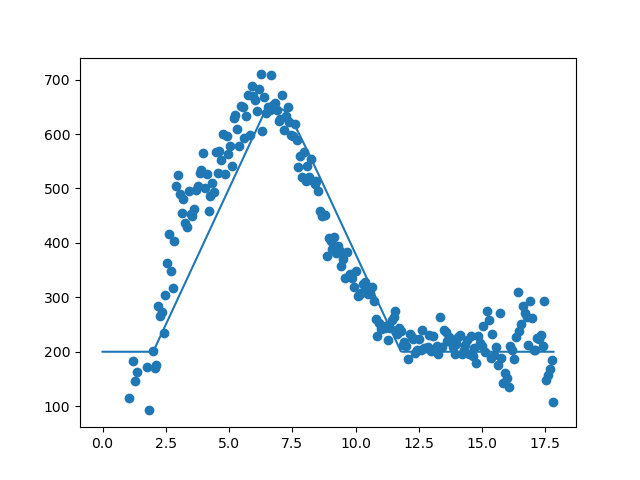

In [226]:
NC14_mask = list(intensity_by_frame[curr_bin]['frame'] >= 400)

x = np.array((intensity_by_frame[curr_bin]['frame'][NC14_mask] - 400)*4.25939/60)
y = np.array(intensity_by_frame[curr_bin]['average_intensity'][NC14_mask])

plt.figure()
plt.scatter(x,y)
plt.plot(x, make_whole_cycle(200,0,6.5,0.5,0.3,100,x))
y

In [218]:
# A function that plots the bin average & fit for a bin

def PlotTrace(x, y, x0=[1,20,20,10,15,100]):
    # initial_guess = [basal0, t_on0, t_dwell0, t_active0, tau0, rate0]
    nan_mask = np.isnan(y)==False
    timepoints = x[nan_mask]
    MS2 = y[nan_mask]
    t_interp = np.linspace(min(timepoints), max(timepoints), 1000)

    basal, t_on, t_dwell, t_active, tau, rate, residual, resnorm, CI = fit_whole_cycle(MS2, timepoints, t_interp, max_nfev=2000, initial_guess=x0)
    
    print("Fitted parameters:")
    print(f"basal: {basal}, t_on: {t_on}, t_dwell: {t_dwell}, t_active: {t_active}, tau: {tau}, rate: {rate}")
    print(f"Residual norm: {resnorm}")
    
    # Print confidence intervals and parameter names
    param_names = ['basal', 't_on', 't_dwell', 't_active', 'tau', 'rate']
    for i, name in enumerate(param_names):
        print(f"{name}: {CI[i]}")
    
    # Plot the fit
    plt.figure()
    plt.plot(timepoints, MS2, label='Data')
    plt.plot(t_interp, make_whole_cycle(basal, t_on, t_dwell, t_active, tau, rate, t_interp), label='Fit')
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.title('Fit of whole cycle')
    plt.legend()
    plt.show()

In [219]:
PlotTrace(x,y,[200,0,6.5,0.5,0.3,100])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

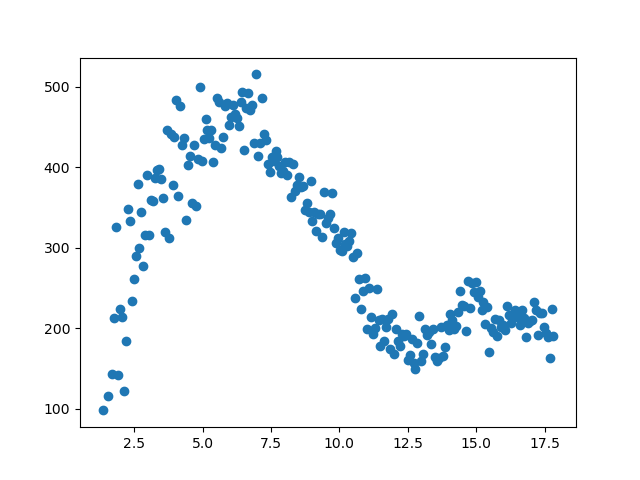

In [156]:
plt.close()
plt.scatter(x,y)
plt.show()

### Plot showing bins

NameError: name 'dataset' is not defined

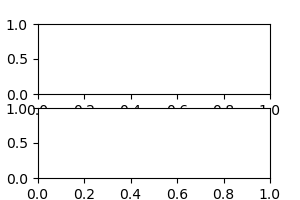

In [23]:
embryo_fig, embryo_ax = plt.subplots(2,1, figsize=(3,2))
embryo_fig.set_dpi(500)
embryo_fig.set
embryo_ax[0].imshow(np.max(dataset.channels_full_dataset[0][370,:,:,:], axis=0), cmap='gray')
embryo_ax[1].imshow(np.max(dataset.channels_full_dataset[0][535,:,:,:], axis=0), cmap='gray')

# 
for i in [0,1]:
    embryo_ax[i].axis('off')

# Add vertical lines
w = 0.2
for b in bin_part:
    embryo_ax[0].axvline(x=b, color='cyan', linestyle='--', linewidth=w)
    embryo_ax[1].axvline(x=b, color='cyan', linestyle='--', linewidth=w)

plt.show()